In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/Вадим/Desktop/GeekBrains/Machine-Learning-in-Business/Lectures/Lectures_5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### Описание ДатаСета

In [3]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [4]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Посмотрим на распределение классов целевом признаке:

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Разделим данные на тренировочную и тестовую выборки

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=42)

Напишем функцию нахождения уровня threshold для оптимального значения Бизнес-метрики

In [36]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_retention_costs=1, revenue_from_retained_customers_rubl=2):
    business_threshold = 0

    rubl_ML_ = -1_000_000

    rs = []
    n = 20
    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя

        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        retain_sum = (FP + TP) * rubl_retention_costs
        income = TP * revenue_from_retained_customers_rubl
        rubl_ML = income - retain_sum

        if rubl_ML > rubl_ML_:
            business_threshold = opt_buisness_tr

            rubl_ML_ = rubl_ML

        rs.append(rubl_ML)

    delta = (max(rs) - min(rs)) * 0.1

    plt.figure(figsize=(6, 4))
    plt.title('"-"Убыток/"+"Доход при применении МЛ решения')
    plt.xlabel('Отсечка')
    plt.ylim([min(rs), max(rs) + delta])
    plt.ylabel('"-"Убыток/"+"Доход')
    plt.plot(np.linspace(0, 1, n), rs)
    plt.grid('on')
    plt.show()
    return business_threshold, rubl_ML_

#### Произведем предобработку данных

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Зададим списки признаков согласно их категории

In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Под каждый признак создадим трансформер и объединим их в список.

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

Объединим все трансформеры используя FeatureUnion и передадим его в Pipeline

In [11]:
from sklearn.pipeline import FeatureUnion

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Добавим модель для обработки подготовленных данных.

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

Обучаем модель на данных.

In [15]:
# обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

#### делаем прогноз для тестовой выборки

In [16]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.01, 0.01, 0.23, 0.11, 0.1 , 0.  , 0.18, 0.28, 0.38, 0.36])

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
                            classification_report, precision_recall_curve, confusion_matrix

Перейдем к меткам классов. 

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.36, F-Score=0.617, Precision=0.643, Recall=0.594


Отрисуем матрицу ошибок

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1852  151]
 [ 210  287]]


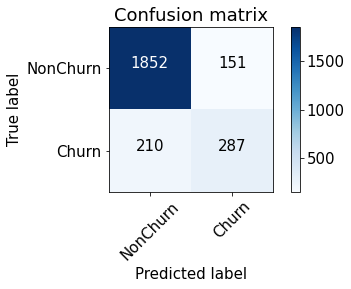

In [31]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### Бизнес метрика

Предположим, что на удержание одного пользователя затрат на 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оценим качество модели на основе RandomForestClassifier с учетом этих данных и ответим на вопрос, является ли применение модели ML экономически целесообразным?

In [41]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum

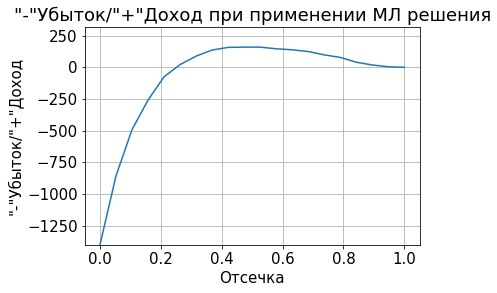

Уровень порога по бизнес метрике 0.474 -  Доход 159
Уровень порога по f1 метрике 0.360 -   Доход 136


In [42]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

- Получили 136 долл. прибыли от применения модели ML на основе RandomForestClassifier<br>
- Получили 159 долл. прибыли от применения модели ML на основе RandomForestClassifier с учетом Бизнес-метрик.<br>

#### Проведем такие же расчеты для модели на RidgeClassifier

In [43]:
from sklearn.linear_model import RidgeClassifier

In [44]:
pipeline_RiCl = Pipeline([
    ('features', feats),
    ('classifier', RidgeClassifier(class_weight={0:1, 1:1.75}, fit_intercept=False, random_state=42)),
])

In [45]:
# обучим наш пайплайн
pipeline_RiCl.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [46]:
preds_RiCl = pipeline_RiCl.predict(X_test)
preds_RiCl[:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
np.array(np.unique(preds_RiCl, return_counts=True)).T

array([[   0, 2129],
       [   1,  371]], dtype=int64)

In [48]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_RiCl)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=1, F-Score=0.456, Precision=0.534, Recall=0.398


Confusion matrix, without normalization
[[1830  173]
 [ 299  198]]


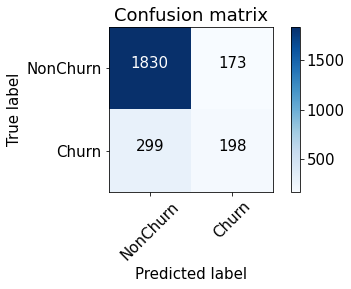

In [49]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_RiCl >= thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [51]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum

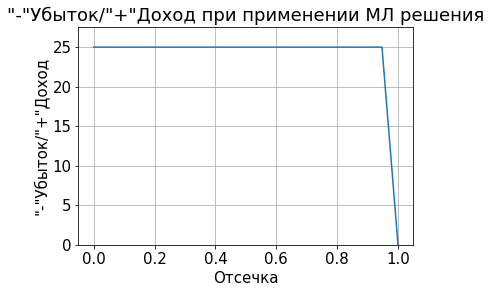

Уровень порога по бизнес метрике 0.000 -  Доход 25
Уровень порога по f1 метрике 1.000 -   Доход 25


In [53]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_RiCl, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

Получили 25$ прибыли от применения модели ML на основе RidgeClassifier

#### Проведем такие же расчеты для модели на DecisionTreeClassifier

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
pipeline_DeTrCl = Pipeline([
    ('features', feats),
    ('classifier', DecisionTreeClassifier(random_state=42)),
])

In [56]:
from sklearn.model_selection import GridSearchCV

In [35]:
params = {
    'classifier__max_depth':[1, 5, 10, 15, 20],
    'classifier__max_features':[0.3, 0.5, 0.7],
    'classifier__min_samples_leaf':[1, 2, 3, 5, 10, 20],
    'classifier__class_weight':[{0:1, 1:4}, {0:1, 1:1.5}, {0:1, 1:1.8}, {0:1, 1:1.85}, {0:1, 1:2.0}, {0:1, 1:2.5}]
}

In [36]:
%%time
grid = GridSearchCV(pipeline_DeTrCl,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 2min 41s
Wall time: 2min 42s


{'classifier__class_weight': {0: 1, 1: 1.5},
 'classifier__max_depth': 5,
 'classifier__max_features': 0.7,
 'classifier__min_samples_leaf': 10}

In [57]:
# обучим наш пайплайн на лучших параметрах
pipeline_DeTrCl = Pipeline([
    ('features', feats),
    ('classifier', DecisionTreeClassifier(max_depth=5, max_features=0.7, 
                                          min_samples_leaf=10, random_state=42,
                                          class_weight={0:1, 1:1.5})),
])
pipeline_DeTrCl.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [58]:
preds_DeTrCl = pipeline_DeTrCl.predict_proba(X_test)[:, 1]
preds_DeTrCl[:10]

array([0.06282723, 0.13681869, 0.32179931, 0.39669421, 0.12942008,
       0.02626263, 0.12942008, 0.23762376, 0.12942008, 0.6481069 ])

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_DeTrCl)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')


Best Threshold=0.39669421487603307, F-Score=0.580, Precision=0.573, Recall=0.588


In [60]:
precision, recall, thresholds

(array([0.19887955, 0.23950617, 0.25157563, 0.27030162, 0.34074662,
        0.37589928, 0.38112858, 0.3998045 , 0.42361863, 0.47820343,
        0.50074516, 0.57254902, 0.58947368, 0.66219839, 0.67032967,
        0.73461538, 0.79207921, 0.80346821, 0.80813953, 0.84285714,
        0.84684685, 0.87378641, 0.87628866, 0.84615385, 0.9047619 ,
        0.89189189, 0.94117647, 1.        ]),
 array([1.        , 0.97585513, 0.9637827 , 0.93762575, 0.86317907,
        0.84104628, 0.82897384, 0.82293763, 0.78672032, 0.72837022,
        0.67605634, 0.58752515, 0.56338028, 0.49698189, 0.49094567,
        0.38430584, 0.32193159, 0.27967807, 0.27967807, 0.23742455,
        0.18913481, 0.18108652, 0.17102616, 0.08853119, 0.07645875,
        0.06639839, 0.03219316, 0.        ]),
 array([0.02626263, 0.06282723, 0.11538462, 0.12942008, 0.13681869,
        0.14285714, 0.18302387, 0.23762376, 0.30851064, 0.32179931,
        0.33922261, 0.39669421, 0.43442623, 0.49253731, 0.60151324,
        0.6481069 , 0.67

In [61]:
fscore

array([0.3317757 , 0.38461538, 0.39900042, 0.4196308 , 0.48861048,
       0.51957738, 0.52217997, 0.53815789, 0.55070423, 0.57735247,
       0.57534247, 0.57994042, 0.57613169, 0.56781609, 0.56678281,
       0.50462351, 0.45779685, 0.41492537, 0.41554559, 0.37048666,
       0.30921053, 0.3       , 0.28619529, 0.16029144, 0.14100186,
       0.12359551, 0.06225681, 0.        ])

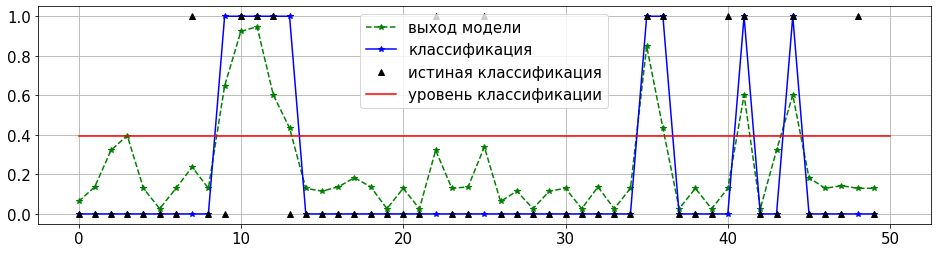

In [62]:
plt.figure(figsize=(16,4))

n = 50
plt.plot(preds_DeTrCl[:n] , '--*g', label = 'выход модели')
plt.plot(preds_DeTrCl[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,n], [thresholds[ix],thresholds[ix]],'r', label = 'уровень классификации')

plt.legend()
plt.show()

Confusion matrix, without normalization
[[1808  195]
 [ 217  280]]


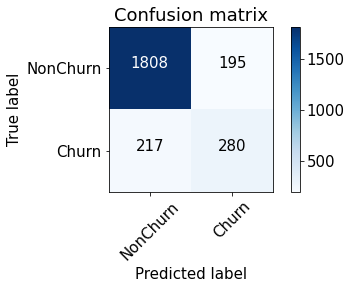

In [63]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_DeTrCl > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [64]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum
f1_income

85

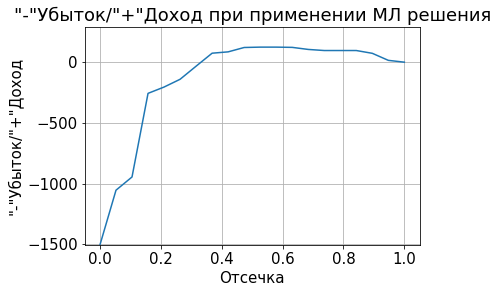

Уровень порога по бизнес метрике 0.526 -  Доход 124
Уровень порога по f1 метрике 0.397 -   Доход 85


In [65]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_DeTrCl, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

- Получили 85 долл. прибыли от применения модели ML на основе DecisionTreeClassifier<br>
- Получили 124 долл. прибыли от применения модели ML на основе DecisionTreeClassifier с учетом Бизнес-метрик.<br> 

#### Проведем такие же расчеты для модели на SGDClassifier

In [66]:
from sklearn.linear_model import SGDClassifier

In [67]:
pipeline_SDG_Cl = Pipeline([
    ('features', feats),
    ('classifier', SGDClassifier(random_state=42)),
])

In [271]:
params = {
    'classifier__verbose':[1, 2, 3, 4, 5],
    'classifier__loss':['log', 'modified_huber', 'squared_hinge'],
    'classifier__class_weight':[{0:1, 1:4}, {0:1, 1:1.5}, {0:1, 1:1.8}, {0:1, 1:2.0}, {0:1, 1:2.5}, {0:1, 1:3}]
}

In [118]:
# %%time
# grid = GridSearchCV(pipeline_SDG_Cl,
#                     param_grid=params,
#                     cv=6,
#                     scoring='f1',
#                     refit=False)

# search = grid.fit(X_train, y_train)
# search.best_params_

In [119]:
# # обучим наш пайплайн на лучших параметрах
# pipeline_SDG_Cl = Pipeline([
#     ('features', feats),
#     ('classifier', SGDClassifier(loss='log', verbose=1, 
#                                           random_state=42,
#                                           class_weight={0:1, 1:3.0})),
# ])
# pipeline_SDG_Cl.fit(X_train, y_train)

In [69]:
preds_SDG_Cl = pipeline_SDG_Cl.predict_proba(X_test)[:, 1]
preds_SDG_Cl[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [70]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_SDG_Cl)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')


Best Threshold=0.0, F-Score=0.332, Precision=0.199, Recall=1.000


In [71]:
thresholds

array([0., 1.])

In [72]:
fscore

array([0.331665  , 0.01195219, 0.        ])

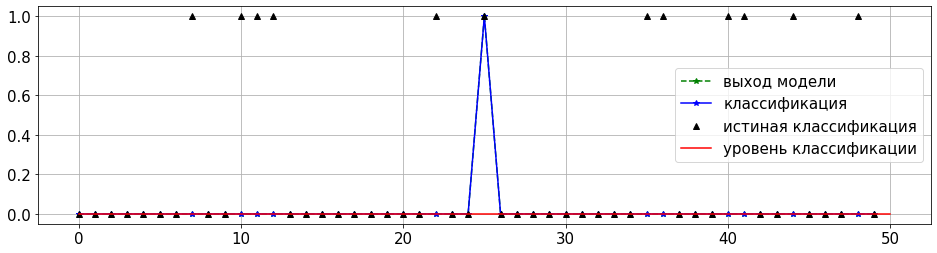

In [73]:
plt.figure(figsize=(16,4))

n = 50
plt.plot(preds_SDG_Cl[:n] , '--*g', label = 'выход модели')
plt.plot(preds_SDG_Cl[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,n], [thresholds[ix],thresholds[ix]],'r', label = 'уровень классификации')

plt.legend()
plt.show()

Confusion matrix, without normalization
[[2001    2]
 [ 494    3]]


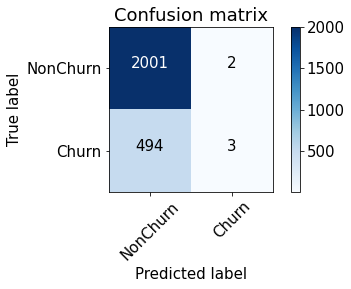

In [74]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_SDG_Cl > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [75]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum
f1_income

1

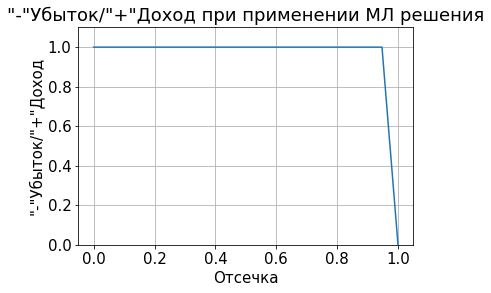

Уровень порога по бизнес метрике 0.000 -  Доход 1
Уровень порога по f1 метрике 0.000 -   Доход 1


In [77]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_SDG_Cl, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

#### Проведем такие же расчеты для модели на KNeighborsClassifier

In [78]:
from sklearn.neighbors import KNeighborsClassifier

In [79]:
pipeline_KNeib_Cl = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier()),
])

In [384]:
params = {
    'classifier__n_neighbors':[3, 4, 5, 6, 7, 8, 9, 10],
    'classifier__algorithm':['ball_tree', 'kd_tree', 'brute'],
}

In [385]:
%%time
grid = GridSearchCV(pipeline_KNeib_Cl,
                    param_grid=params,
                    cv=6,
                    scoring='f1',
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 1min 42s
Wall time: 31.3 s


{'classifier__algorithm': 'ball_tree', 'classifier__n_neighbors': 3}

In [80]:
# обучим наш пайплайн на лучших параметрах
pipeline_KNeib_Cl = Pipeline([
    ('features', feats),
    ('classifier', KNeighborsClassifier(n_neighbors=3)),
])
pipeline_KNeib_Cl.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [81]:
preds_KNeib_Cl = pipeline_KNeib_Cl.predict_proba(X_test)[:, 1]
preds_KNeib_Cl[:10]

array([0.        , 0.33333333, 0.        , 0.66666667, 0.        ,
       0.        , 0.33333333, 0.33333333, 0.33333333, 0.33333333])

In [82]:
np.array(np.unique(preds_KNeib_Cl, return_counts=True)).T

array([[0.00000000e+00, 1.26300000e+03],
       [3.33333333e-01, 9.65000000e+02],
       [6.66666667e-01, 2.43000000e+02],
       [1.00000000e+00, 2.90000000e+01]])

In [83]:
y_test.value_counts()

0    2003
1     497
Name: Exited, dtype: int64

In [85]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_KNeib_Cl)

In [86]:
precision, recall, thresholds

(array([0.1988    , 0.20776071, 0.21691176, 0.24137931, 1.        ]),
 array([1.        , 0.51710262, 0.11871227, 0.01408451, 0.        ]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]))

In [87]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [88]:
fscore = (2 * precision * recall) / (precision + recall)
fscore

array([0.331665  , 0.29642445, 0.15344603, 0.02661597, 0.        ])

In [89]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
# ix = 11
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.0, F-Score=0.332, Precision=0.199, Recall=1.000


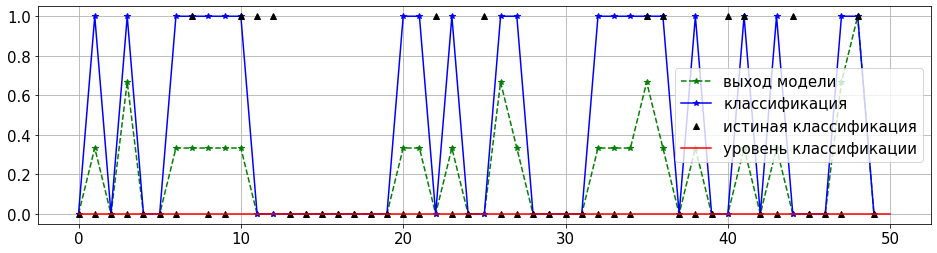

In [90]:
plt.figure(figsize=(16,4))

n = 50
plt.plot(preds_KNeib_Cl[:n] , '--*g', label = 'выход модели')
plt.plot(preds_KNeib_Cl[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,n], [thresholds[ix], thresholds[ix]],'r', label = 'уровень классификации')

plt.legend()
plt.show()

Confusion matrix, without normalization
[[1023  980]
 [ 240  257]]


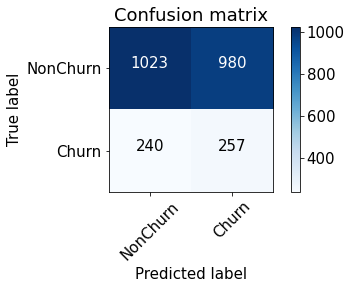

In [91]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_KNeib_Cl > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [92]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum
f1_income

-723

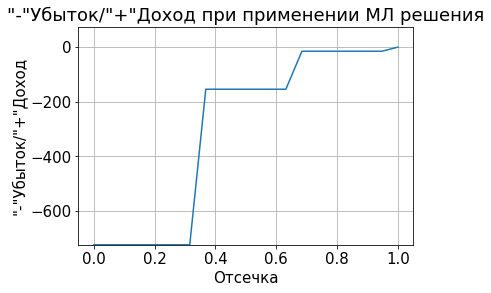

Уровень порога по бизнес метрике 1.000 -  Доход 0
Уровень порога по f1 метрике 0.000 -   Доход -723


In [93]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_KNeib_Cl, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

#### Проведем такие же расчеты для модели на BaggingClassifier

In [94]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [95]:
pipeline_Bagg_Cl = Pipeline([
    ('features', feats),
    ('classifier', BaggingClassifier(random_state=42)),
])

In [282]:
params = {
    'classifier__n_estimators':[3, 5, 10, 15, 20],
}

In [381]:
%%time
grid = GridSearchCV(pipeline_Bagg_Cl,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

CPU times: total: 12 s
Wall time: 12 s


{'classifier__n_estimators': 20}

In [96]:
# обучим наш пайплайн на лучших параметрах
pipeline_Bagg_Cl = Pipeline([
    ('features', feats),
    ('classifier', BaggingClassifier(n_estimators=20, random_state=42)),
])
pipeline_Bagg_Cl.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [97]:
preds_Bagg_Cl = pipeline_Bagg_Cl.predict_proba(X_test)[:, 1]
preds_Bagg_Cl[:10]

array([0.  , 0.  , 0.45, 0.15, 0.05, 0.  , 0.35, 0.2 , 0.2 , 0.05])

In [120]:
# np.array(np.unique(preds_Bagg_Cl, return_counts=True)).T

In [99]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_Bagg_Cl)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')


Best Threshold=0.45, F-Score=0.593, Precision=0.632, Recall=0.559


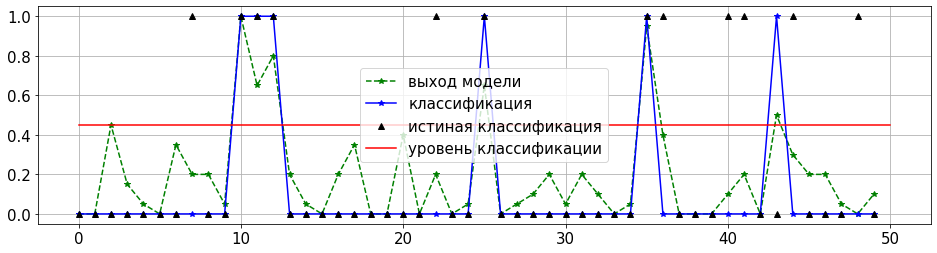

In [100]:
plt.figure(figsize=(16,4))

n = 50
plt.plot(preds_Bagg_Cl[:n] , '--*g', label = 'выход модели')
plt.plot(preds_Bagg_Cl[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,n], [thresholds[ix], thresholds[ix]],'r', label = 'уровень классификации')

plt.legend()
plt.show()

Confusion matrix, without normalization
[[1884  119]
 [ 240  257]]


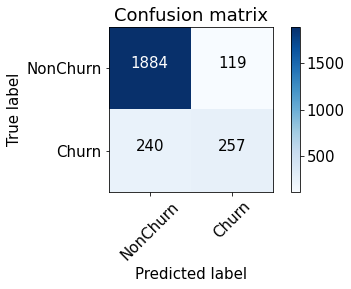

In [101]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_Bagg_Cl > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [102]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum
f1_income

138

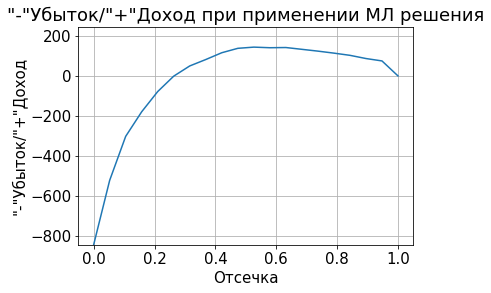

Уровень порога по бизнес метрике 0.526 -  Доход 144
Уровень порога по f1 метрике 0.450 -   Доход 138


In [103]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_Bagg_Cl, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

- Получили 138 долл. прибыли от применения модели ML на основе BaggingClassifier<br>
- Получили 144 долл. прибыли от применения модели ML на основе BaggingClassifier с учетом Бизнес-метрик.<br> 

#### Проведем такие же расчеты для модели на LogisticRegression

In [104]:
pipeline_LogReg = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(class_weight={0:1, 1:8}, random_state=42)),
])
pipeline_LogReg.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [105]:
preds_LogReg = pipeline_LogReg.predict_proba(X_test)[:, 1]
preds_LogReg[:10]

array([0.62074142, 0.63798182, 0.68609214, 0.92043909, 0.58779311,
       0.41512614, 0.7598899 , 0.46594422, 0.6963431 , 0.79904572])

In [121]:
# np.array(np.unique(preds_LogReg, return_counts=True)).T

In [107]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_LogReg)
precision, recall, thresholds

(array([0.2       , 0.19967794, 0.19975836, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.99798793, 0.99798793, ..., 0.        , 0.        ,
        0.        ]),
 array([0.26558732, 0.26744513, 0.26950331, ..., 0.97762603, 0.97831659,
        0.98242848]))

In [108]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')


Best Threshold=0.9673329464094594, F-Score=nan, Precision=0.000, Recall=0.000


In [110]:
f_sc = pd.Series(fscore)
f_sc.fillna(0, inplace=True)
ix = np.argmax(f_sc)
ix

1658

In [111]:
fscore[ix]

0.4607250755287009

In [112]:
precision[ix], recall[ix], thresholds[ix]

(0.3688029020556227, 0.613682092555332, 0.7074176521431984)

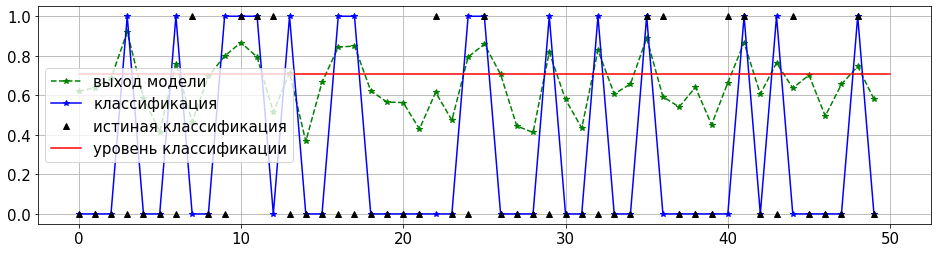

In [113]:
plt.figure(figsize=(16,4))

n = 50
plt.plot(preds_LogReg[:n] , '--*g', label = 'выход модели')
plt.plot(preds_LogReg[:n] > thresholds[ix], '-*b', label = 'классификация')
plt.plot(y_test.values[:n], '^k', label = 'истиная классификация')
plt.grid('on')

plt.plot([0,n], [thresholds[ix], thresholds[ix]],'r', label = 'уровень классификации')

plt.legend()
plt.show()

Confusion matrix, without normalization
[[1728  275]
 [ 293  204]]


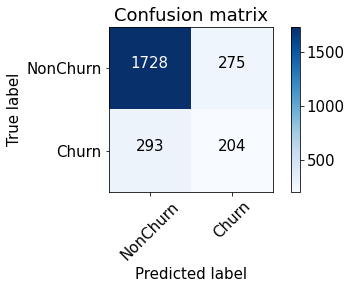

In [114]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_LogReg > 0.7750)
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [115]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
retain_sum = (FP + TP) * 1
income = TP * 2

f1_income = income - retain_sum
f1_income

-71

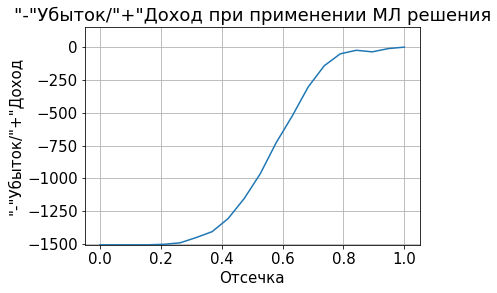

Уровень порога по бизнес метрике 1.000 -  Доход 0
Уровень порога по f1 метрике 0.707 -   Доход -71


In [116]:
busines_tr, bus_income = business_threshold_calibrate(y_test, preds_LogReg, 
                                          thresholds[ix],
                                          rubl_retention_costs=1, 
                                          revenue_from_retained_customers_rubl=2)

print(f'Уровень порога по бизнес метрике {busines_tr:0.3f} -  Доход {bus_income}')
print(f'Уровень порога по f1 метрике {thresholds[ix]:0.3f} -   Доход {f1_income}')

## Итоги

### Лучшие модели

1. RandomForestClassifier
- Получили 136 долл. прибыли от применения модели ML на основе RandomForestClassifier<br>
- Получили 159 долл. прибыли от применения модели ML на основе RandomForestClassifier с учетом Бизнес-метрик.<br>

2. BaggingClassifier (по умолчанию оценщик DecisionTreeClassifier)
- Получили 138 долл. прибыли от применения модели ML на основе BaggingClassifier <br>
- Получили 144 долл. прибыли от применения модели ML на основе BaggingClassifier с учетом Бизнес-метрик.<br> 